In [1]:
import matplotlib.pyplot as plt
import matplotlib
import math
import numpy as np
import random
import cv2

%matplotlib inline
np.set_printoptions(suppress=True)
matplotlib.rcParams['figure.figsize'] = (14, 14)

def plot2d(image, title="", max=None, min=0, cmap="gray", switch_channels=True):
    plt.title(title)
    if not switch_channels or image.ndim == 2:
        if max == None:
            plt.imshow(image, cmap=cmap, interpolation="none")
        else:
            plt.imshow(image, cmap=cmap, interpolation="none", vmin = min, vmax = max)
    else:
        if max == None:
            plt.imshow(image[:,:,::-1], cmap=cmap, interpolation="none")
        else:
            plt.imshow(image[:,:,::-1], cmap=cmap, interpolation="none", vmin = min, vmax = max)
    plt.show()

def show(image, title="", bw=True):
    if bw:
        plt.imshow(image,cmap="Greys_r", vmin=0, vmax=255)
    else:
        plt.imshow(image.astype(np.uint8), vmin=0, vmax=255)
    plt.title(title)
    plt.show()

# im1 = cv2.imread("1.jpg")
# im2 = cv2.imread("2.jpg")
# im3 = cv2.imread("3.jpg")
# im4 = cv2.imread("4.jpg")

# im1 = cv2.imread("campus1_1200.png")
# im2 = cv2.imread("campus2_1200.png")
# im3 = cv2.imread("campus3_1200.png")



In [2]:
def stitch_images(images, match_threshold = 750, ransac_threshold = 5, verbose=False):
#     images = map(lambda img: cv2.resize(img, (600,600)), images)
    images_orig = images
    images = map(lambda img: cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), images)
    feature_sets = find_features(images_orig, images, verbose)
    matches = match_feature_sets(feature_sets, match_threshold, verbose)
    homographies = ransac_images(matches, feature_sets, ransac_threshold, False)
    warped_images= warp_images(homographies, images_orig)
    stitched_image = composite_images(warped_images)
    return stitched_image
    
    
        
def draw_sidebyside(im1, im2):
    h1,w1 = im1.shape
    h2,w2 = im2.shape
    out = np.zeros((h1, w1+w2, 3), dtype=float)
    out[:,:w1,0] = im1
    out[:,:w1,1] = im1
    out[:,:w1,2] = im1
    out[:,w1:,0] = im2
    out[:,w1:,1] = im2
    out[:,w1:,2] = im2
    return out, w1,w2
    
    
def draw_samples(random_sample, set1, set2, image1, image2):
    out,w1,w2 = draw_sidebyside(image1,image2)
    
    for s in random_sample:
        s1 = set1[1][s.queryIdx].pt
        s2 = set2[1][s.trainIdx].pt
        cv2.circle(out, (int(s1[0]), int(s1[1])), 8, (255,255,255), 4)
        cv2.circle(out, (int(w1 + s2[0]), int(s2[1])), 8, (255,255,255), 4)
    return out

def ransac_image(matches, set1, set2, threshold, verbose=False):
    n = len(matches) # Number of data points
    m = 4 # Minimum needed for homography
    p = 0.5 # Portion of n points that we believe to be inliers (underestimate)
    confidence = 0.99 # Confidence that we've picked the correct solution
    #confidence = 1 - (1 - p ** m) ** k # Number of RANSAC interations needed
    k = math.log(1 - confidence, (1 - p ** m)) # Solve for k to find number of iterations to achieve desired confidence
    k = int(math.ceil(k))
    
    consensus_sets = []
    for i in range(k):
        random_sample = []
        for j in range(m):
            random_sample.append(random.choice(matches))
        
        if verbose:
            out = draw_samples(random_sample, set1, set2, set1[0], set2[0])
            plot2d(out)
            
        homography, cs_size = calculate_consensus_set_size(random_sample, matches, set1, set2, threshold, verbose)
        cs_item = (random_sample, homography, cs_size)
        consensus_sets.append(cs_item)
    
    largest_consensus_set = max(consensus_sets, key=lambda s: s[2])
    return largest_consensus_set[1]
    
    
    
def ransac_images(matches_lists, feature_sets, threshold, verbose=False):
    homographies = []
    for i in range(len(matches_lists)):
        matches = matches_lists[i]
        set1 = feature_sets[i]
        set2 = feature_sets[i + 1]
        homography = ransac_image(matches, set1, set2,
                                  threshold,
                                  verbose)
        homographies.append(homography)
    return homographies
        
        
    
def find_features(images_orig, images, verbose=False):
    sift = cv2.xfeatures2d.SIFT_create()
    feature_sets = []
    for i in range(len(images)):
        keypoints, descriptors = sift.detectAndCompute(images[i], None)
        if verbose:
            im = cv2.drawKeypoints(images[i], keypoints,images[i], flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
            plot2d(im)
        feature_set = (images[i],keypoints, descriptors, images_orig[i])
        feature_sets.append(feature_set)
    return feature_sets


def find_putative_matches(set1, set2, threshold, verbose=False):
    bf_matcher = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
    putative_matches = bf_matcher.match(set1[2], set2[2])
    thresholded = [x for x in putative_matches if x.distance < threshold]
    if verbose:
        out_img = None
        out_img = cv2.drawMatches(set1[0], set1[1], set2[0], set2[1], thresholded, out_img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        plot2d(out_img)
    return thresholded
    
        
def match_feature_sets(feature_sets, threshold, verbose):
    putative_matches_lists = []
    for i in range(1, len(feature_sets)):
#     for i in range(1, len(feature_sets) + 1):
        feature_set1 = feature_sets[i - 1]
        feature_set2 = feature_sets[i]
#         feature_set2 = feature_sets[i % len(feature_sets)]
        putative_matches = find_putative_matches(feature_set1, feature_set2, threshold, verbose)
        putative_matches_lists.append(putative_matches)
    return putative_matches_lists
        




In [3]:
# Homography stuff
def estimate_homography(s1, s2):
    x1 = s1[0].pt[0]
    y1 = s1[0].pt[1]
    X1 = s2[0].pt[0]
    Y1 = s2[0].pt[1]
    
    x2 = s1[1].pt[0]
    y2 = s1[1].pt[1]
    X2 = s2[1].pt[0]
    Y2 = s2[1].pt[1]
    
    x3 = s1[2].pt[0]
    y3 = s1[2].pt[1]
    X3 = s2[2].pt[0]
    Y3 = s2[2].pt[1]
    
    x4 = s1[3].pt[0]
    y4 = s1[3].pt[1]
    X4 = s2[3].pt[0]
    Y4 = s2[3].pt[1]
    
    A = np.array(
    [[x1, y1, 1,  0,  0, 0, -X1 * x1, -X1 * y1],
     [ 0,  0, 0, x1, y1, 1, -Y1 * x1, -Y1 * y1],
     [x2, y2, 1,  0,  0, 0, -X2 * x2, -X2 * y2],
     [ 0,  0, 0, x2, y2, 1, -Y2 * x2, -Y2 * y2],
     [x3, y3, 1,  0,  0, 0, -X3 * x3, -X3 * y3],
     [ 0,  0, 0, x3, y3, 1, -Y3 * x3, -Y3 * y3],
     [x4, y4, 1,  0,  0, 0, -X4 * x4, -X4 * y4],
     [ 0,  0, 0, x4, y4, 1, -Y4 * x4, -Y4 * y4]],
        dtype=float)
    b = np.array(
    [[X1],
     [Y1],
     [X2],
     [Y2],
     [X3],
     [Y3],
     [X4],
     [Y4]],
        dtype=float)
    
    if np.linalg.det(A) != 0:
        x = np.linalg.solve(A, b)
        x = np.array(
        [[x[0], x[1], x[2]],
         [x[3], x[4], x[5]],
         [x[6], x[7],   1]], dtype=float)
        return x
    else:
        return None
        
def project_match(homography, match, set1):
    p1 = set1[1][match.queryIdx].pt
    h = homography
    
    x = p1[0]
    y = p1[1]
    
    X = (h[0,0] * x + h[0,1] * y + h[0,2]) / (h[2,0] * x + h[2,1] * y + 1.0)
    Y = (h[1,0] * x + h[1,1] * y + h[1,2]) / (h[2,0] * x + h[2,1] * y + 1.0)
    
    P_est = np.array(
    [[X],
     [Y]], dtype=float)
    return P_est
    
    
def draw_projected(Ps, image1, image2):
    out,w1,w2 = draw_sidebyside(image1,image2)
    for p in Ps:
        orig = p[0]
        actual = p[1]
        est = p[2]
        cv2.circle(out, (orig[0], orig[1]), 8, (0,255,0), 2)
        cv2.line(out, (w1+actual[0], actual[1]), (w1+est[0], est[1]), (0,0,255), 4)
        cv2.circle(out, (w1+actual[0], actual[1]), 8, (0,255,0), 2)
        cv2.circle(out, (w1+est[0], est[1]), 8, (255,0,0), 2)
    return out

def calculate_consensus_set_size(random_sample, matches, set1, set2, threshold, verbose=False):
    sample_set1 = map(lambda p: set1[1][p.queryIdx], random_sample)
    sample_set2 = map(lambda p: set2[1][p.trainIdx], random_sample)
    homography = estimate_homography(sample_set1, sample_set2)
    if homography is None:
#         print "Singular Matrix!"
        return None, 0
    cs_size = 0
    
    if verbose:
        Ps = []
        Ps_close = []
    for match in matches:
        p1 = set1[1][match.queryIdx].pt
        P_orig = np.array(
        [[p1[0]],
         [p1[1]]], dtype=float)
        p2 = set2[1][match.trainIdx].pt
        P_actual = np.array(
        [[p2[0]], 
         [p2[1]]], dtype=float)
        P_est = project_match(homography, match, set1)
        
        error = np.linalg.norm(P_actual - P_est)
        if error < threshold:
            cs_size += 1
            if verbose:
                Ps_close.append((P_orig, P_actual, P_est))
        if verbose:
#             print error
            Ps.append((P_orig, P_actual, P_est))
    
    if verbose:
        out = draw_projected(Ps_close[::], set1[0], set2[0])
        plot2d(out, switch_channels=True)
        cv2.imwrite("projected.png", out)
    
    return (homography, cs_size)


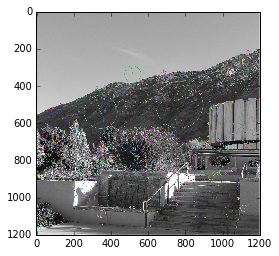

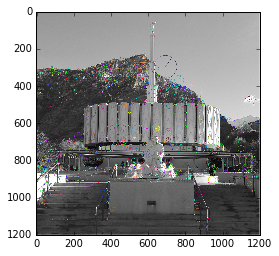

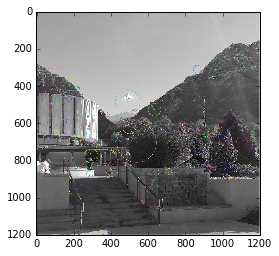

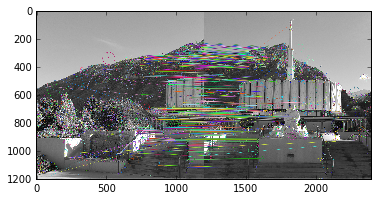

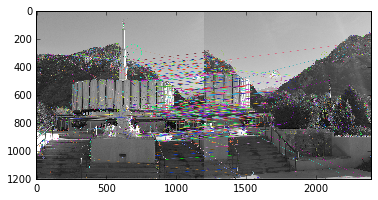

True

In [7]:
def combine_homographies(homographies):
    M = homographies[0]
    M /= M[2,2]
    h = [M]
    for i in range(len(homographies)):
        M = np.matmul( M, np.linalg.inv(homographies[i]))
        M /= M[2,2]
        h.append(M)
    return h
        
def find_extents(homographies, image_sizes):
    minX = 0
    minY = 0
    maxX = 0
    maxY = 0
    for i in range(len(homographies)):
        im = image_sizes[i]
        tl = np.array([[0],[0],[1]], dtype=float)
        tr = np.array([[im[1]],[0],[1]], dtype=float)
        bl = np.array([[0],[im[0]],[1]], dtype=float)
        br = np.array([[im[1]],[im[0]],[1]], dtype=float)

        tl = np.matmul(homographies[i], tl)
        tr = np.matmul(homographies[i], tr)
        bl = np.matmul(homographies[i], bl)
        br = np.matmul(homographies[i], br)

        tl /= tl[2]
        tr /= tr[2]
        bl /= bl[2]
        br /= br[2]

        minX = min(minX, tl[0,0], bl[0,0], tr[0,0], br[0,0])
        minY = min(minY, tl[1,0], bl[1,0], tr[1,0], br[1,0])
        maxX = max(maxX, tl[0,0], bl[0,0], tr[0,0], br[0,0])
        maxY = max(maxY, tl[1,0], bl[1,0], tr[1,0], br[1,0])
        
    return minX, minY, maxX, maxY
        
    
        
def shift_homographies(homographies, minX, minY):
    out = []
    for h in homographies:
        shift = np.array(
        [[1, 0, -minX],
         [0, 1, -minY],
         [0, 0,     1]], dtype=float)
        m = np.matmul(shift, h)
        m /= m[2,2]
        out.append(m)
    return out

def warp_images(homographies, images, verbose=False):
    homographies = combine_homographies(homographies)
    minX, minY, maxX, maxY = find_extents(homographies, map(lambda i: i.shape, images))
    homographies = shift_homographies(homographies, minX,minY)
    w = int(math.ceil(maxX - minX))
    h = int(math.ceil(maxY - minY))
    
    warped_images = []
    for i in range(len(images)):
        M = homographies[i]
        warped = cv2.warpPerspective(images[i], M, (w, h))
        white = np.ones((images[i].shape[0], images[i].shape[1], 3), dtype=float)
        mask = cv2.warpPerspective(white, M, (w,h))
        warped_images.append((warped,mask))
        if verbose:
            plot2d(warped)
            cv2.imwrite(str(i) + ".png", warped)
    return warped_images

def find_mask_extents(mask):
    minX = mask.shape[1]
    maxX = 0
    for i in range(mask.shape[0]):
        indices = np.where(mask[i] > 0)
        if indices[0].shape[0] > 0:
            first_index = indices[0][0]
            last_index = indices[0][-1]
        else:
            first_index = minX
            last_index = maxX
        if first_index < minX:
            minX = first_index
        if last_index > maxX:
            maxX = last_index
    return minX,maxX
        
    
def make_gradient(img_w, img_h, minX, maxX):
    width = maxX - minX
    u = np.linspace(start=0, stop=1, num=width, endpoint=True, dtype='float64')
    t = np.linspace(start=0, stop=1, num=img_h, endpoint=True, dtype='float64')
    x,y = np.meshgrid(u, t)
    
    gradient = np.zeros((img_h,img_w, 3), dtype=float)
    gradient[:,minX:maxX, 0] = x
    gradient[:,minX:maxX, 1] = x
    gradient[:,minX:maxX, 2] = x
    return gradient

def blend_mask(mask, prev_mask):
    intersect = np.logical_and(mask, prev_mask)
    minX,maxX = find_mask_extents(intersect)
    gradient = make_gradient(mask.shape[1], mask.shape[0], minX, maxX + 1)
    out = gradient * intersect
    subtraction = mask - intersect
    out = out + subtraction
    return out
    
def composite_images(warped_images):
    out = np.zeros((warped_images[0][0].shape), dtype=float)
    for i in range(len(warped_images)):
        img, mask = warped_images[i]
        prev_img, prev_mask = warped_images[i-1]
        if i > 0:
            mask = blend_mask(mask, prev_mask)
        out = (img * mask) + (out * (1 - mask))
        out[out < 0] = 0
        out[out > 255] = 255
    return out


im1 = cv2.imread("temple_horiz1_1200.png")
im2 = cv2.imread("temple_horiz2_1200.png")
im3 = cv2.imread("temple_horiz3_1200.png")
images = [im1, im2, im3]
stitched = stitch_images(images, verbose=True)
cv2.imwrite("stitched.png", stitched)
